# Visualization

This notebook visualizes the PCam$^{1}$ dataset, retrieved from [Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/).

**References:**

1. B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962

## Set Up

In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch.utils import data
from torchvision import datasets, transforms

import lib.histopathology as hcd

In [2]:
DATASET_PATH = '../data'

## Create Datasets and DataLoaders

A PyTorch `DataLoader` is created for each of the following datasets:

1. Loader with ground truth labels for the train set.

2. Loader without labels for the train set.

3. Loader without labels for the test set.

In [3]:
image_dir = os.path.join(DATASET_PATH, 'train')
csv_path = os.path.join(DATASET_PATH, 'train_labels.csv')
# A labelled PCam train set (1.)
pcam_dataset = hcd.dataset.PCam(image_dir, csv_path, transform=transforms.Compose([transforms.ToTensor()]))
# Corresponding DataLoader
train_loader = data.DataLoader(pcam_dataset, batch_size=50, num_workers=0)

In [4]:
# An unlabelled PCam train set (2.)
ul_train_set = hcd.dataset.UnlabeledPcam(os.path.join(DATASET_PATH, 'train'), 
                                         transforms.Compose([transforms.ToTensor()]))
# An unlabelled PCam test set (3.)
ul_test_set = hcd.dataset.UnlabeledPcam(os.path.join(DATASET_PATH, 'test'), 
                                        transforms.Compose([transforms.ToTensor()]))
# Corresponding DataLoaders
ul_train_loader = data.DataLoader(ul_train_set, batch_size=50, num_workers=0)
ul_test_loader = data.DataLoader(ul_test_set, batch_size=50, num_workers=0)

## List Dataset Metrics

Determine the following metrics for the datasets:

1. Number of images and their shape for train set.

2. Number of images and their shape for test set.

3. Distribution of positive and negative instances in the train set.

In [5]:
print(f'PCam train set has {len(ul_train_set)} labeled images of shape {tuple(ul_train_set[0].shape)}.')
print(f'PCam test set has {len(ul_test_set)} unlabeled images of shape {tuple(ul_test_set[0].shape)}.')

PCam train set has 220025 labeled images of shape (3, 96, 96).
PCam test set has 57458 unlabeled images of shape (3, 96, 96).


## Visualize Some Images from Each Class

In [6]:
df = pcam_dataset.labels_df
neg, pos = df.label.value_counts().values
pos_pct = pos / (pos + neg) * 100
neg_pct = neg / (pos + neg) * 100
print(f'PCam train set is {pos_pct:.4f}% positive ({pos} examples), and {neg_pct:.4f}% negative ({neg} examples).')

PCam train set is 40.5031% positive (89117 examples), and 59.4969% negative (130908 examples).


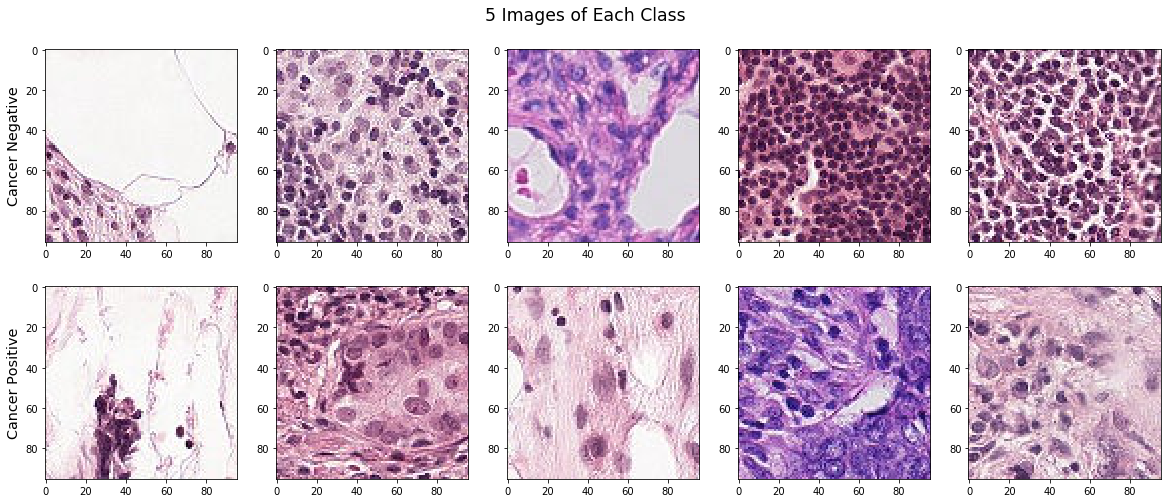

In [7]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('5 Images of Each Class', size='xx-large', y=0.95)
images, labels = next(iter(train_loader))
labels = labels.flatten()
images = images.permute(0,2,3,1).numpy()
for i in range(2):
    class_images = images[labels == i][:5]
    ax[i,0].set_ylabel(f'Cancer {"Positive" if i == 1 else "Negative"}', size='x-large')
    for j in range(5):
        ax[i,j].imshow(class_images[j])
plt.savefig('../figures/5_images_of_each_class.png')

## Histograms of Dataset Intensities

Create histograms visualizing the channel-wise distribution of pixel intensities.

### 1. Combined Test and Train Set

In [ ]:
COLORS_RGB = ('#EE204D', '#3BB08F', '#1CA9C9')

In [ ]:
def pcam_histogram(bins, buckets, data_loader, first_batch, n_batches):
    start = time.time()
    for b, images in enumerate(data_loader, start=first_batch):
        images = images.permute(1, 2, 3, 0).numpy().reshape((3,-1))
        # For each channel, compute the distibution of pixel intensities
        for i in range(3):
            buckets[i] += np.histogram(images[i], bins)[0]
        # The last bin should include the maximum value (1.0)
        buckets[:,-1] += np.sum(images == 1.0, axis=1)
        if b % 500 == 0:
            print(f'Batch[{b}/{n_batches}]: Finished distibuting pixels in {(time.time()-start):.6f}s.')
    print(f'Finished binning dataset in {(time.time()-start):.6f}s.')

In [ ]:
bins = np.linspace(0, 1, 11)
buckets = np.zeros((3, len(bins)-1))
n_batches = len(ul_train_loader) + len(ul_test_loader)
pcam_histogram(bins, buckets, ul_train_loader, first_batch=1, n_batches=n_batches)
pcam_histogram(bins, buckets, ul_test_loader, first_batch=len(ul_train_loader)+1, n_batches=n_batches)

In [ ]:
plt.subplots_adjust(hspace=0.3, wspace=0.5)
fig, ax = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Channel-wise Pixel Intensities', size='x-large', va='bottom', y=0.93)
for i, color in zip(range(3), COLORS_RGB):
    ax[i].bar(bins[1:]-0.05, height=buckets[i], width=0.1, color=color, lw=0.5, edgecolor='k')
    ax[i].set_xlabel('Intensity')
    ax[i].set_ylabel('Pixels')
ax[0].set_title('R Channel')
ax[1].set_title('G Channel')
ax[2].set_title('B Channel')
plt.savefig('../figures/channel_pixel_intensities.png')

### 2. Train Set Only

In [ ]:
bins = np.linspace(0, 1, 11)
start = time.time()
pos_buckets = np.zeros((3, len(bins)-1))
neg_buckets = np.zeros((3, len(bins)-1))
num_batches = len(train_loader)
for b, (images, labels) in enumerate(train_loader, start=1):
    labels = labels.flatten().numpy()
    pos_images = images[labels == 1].permute(1, 2, 3, 0).numpy().reshape((3,-1))
    neg_images = images[labels == 0].permute(1, 2, 3, 0).numpy().reshape((3,-1))
    # For each channel, compute the distibution of pixel intensities
    for i in range(3):
        pos_buckets[i] += np.histogram(pos_images[i], bins)[0]
        neg_buckets[i] += np.histogram(neg_images[i], bins)[0]
    # The last bin should include the maximum value (1.0)
    pos_buckets[:,-1] += np.sum(pos_images == 1.0, axis=1)
    neg_buckets[:,-1] += np.sum(neg_images == 1.0, axis=1)
    if b % 500 == 0:
        print(f'Batch[{b}/{n_batches}]: Finished distibuting pixels in {(time.time()-start):.6f}s.')
print(f'Finished binning dataset in {(time.time()-start):.6f}s.')

In [ ]:
plt.subplots_adjust(hspace=0.3, wspace=0.5)
fig, ax = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Channel-wise Pixel Intensities', size='x-large', va='bottom', y=0.93)
for i, color in zip(range(3), ('#EE204D', '#3BB08F', '#1CA9C9')):
    ax[i].bar(bins[1:]-0.05, height=pos_buckets[i]+neg_buckets[i], width=0.1, color=color, lw=0.5, edgecolor='k')
    ax[i].set_xlabel('Intensity')
    ax[i].set_ylabel('Pixels')
ax[0].set_title('R Channel')
ax[1].set_title('G Channel')
ax[2].set_title('B Channel')
plt.savefig('../figures/channel_pixel_intensities_train.png')

### 3. Train Set Split on Class Labels

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(16,10))
fig.suptitle('Channel-wise Pixel Intensities by Class', size='x-large', va='bottom', y=0.92)
for i, color in zip(range(3), ('#EE204D', '#3BB08F', '#1CA9C9')):
    ax[0,i].bar(bins[1:]-0.05, height=pos_buckets[i], width=0.1, color=color, lw=0.5, edgecolor='k')
    ax[1,i].bar(bins[1:]-0.05, height=neg_buckets[i], width=0.1, color=color, lw=0.5, edgecolor='k')
    ax[0,i].set_xlabel('Intensity')
    ax[0,i].set_ylabel('Pixels')
    ax[1,i].set_xlabel('Intensity')
    ax[1,i].set_ylabel('Pixels')
ax[0,0].set_title('R Channel (Cancer Positive)', size='large')
ax[1,0].set_title('R Channel (Cancer Negative)', size='large')
ax[0,1].set_title('G Channel (Cancer Positive)', size='large')
ax[1,1].set_title('G Channel (Cancer Negative)', size='large')
ax[0,2].set_title('B Channel (Cancer Positive)', size='large')
ax[1,2].set_title('B Channel (Cancer Negative)', size='large')
plt.savefig('../figures/channel_pixel_intensities_by_class_train.png')

## Visualizations of Transforms

The following tranforms were applied to this dataset:

1. Random Rotation
2. Morphological Closing
3. Center Cropping
4. Scaling of Inputs to the $[0, 1]$ Range
5. Channel-Wise Mean Normalization

In [7]:
pcam_dataset = hcd.dataset.UnlabeledPcam(image_dir, transform=None)
# shuffle_loader = data.DataLoader(pcam_dataset, batch_size=5, shuffle=True)

In [8]:
rgb_means = [0.70025474, 0.54378763, 0.6961546]
rgb_stds = [0.23917262, 0.28227101, 0.2156419]

In [9]:
transform_image = transforms.Compose([
    hcd.transforms.ToClosed(),
    transforms.RandomRotation(90),
    transforms.CenterCrop(48),
    transforms.ToTensor(),
    hcd.transforms.ToNormalized(rgb_means, rgb_stds)
])

transform_image_no_morph = transforms.Compose([
    transforms.RandomRotation(90),
    transforms.CenterCrop(48),
    transforms.ToTensor(),
    hcd.transforms.ToNormalized(rgb_means, rgb_stds)
])

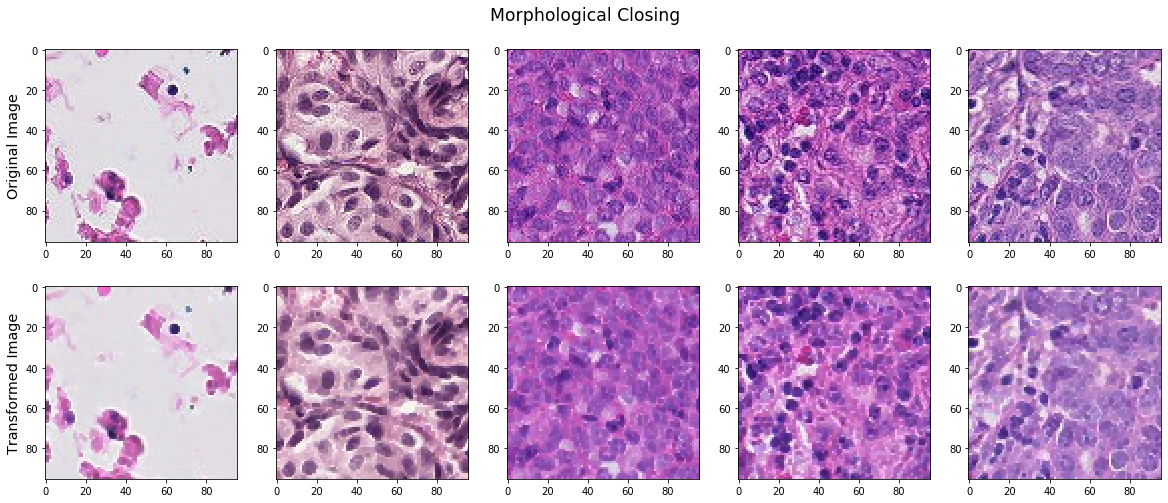

In [12]:
morph_close = hcd.transforms.ToClosed()
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Morphological Closing', size='xx-large', y=0.95)
for i in range(5):
    ax[0, i].imshow(pcam_dataset[i])
    T = morph_close(pcam_dataset[i])
    ax[1, i].imshow(T)
ax[0,0].set_ylabel(f'Original Image', size='x-large')
ax[1,0].set_ylabel(f'Transformed Image', size='x-large')
plt.savefig('../figures/morph_close_transform.png')

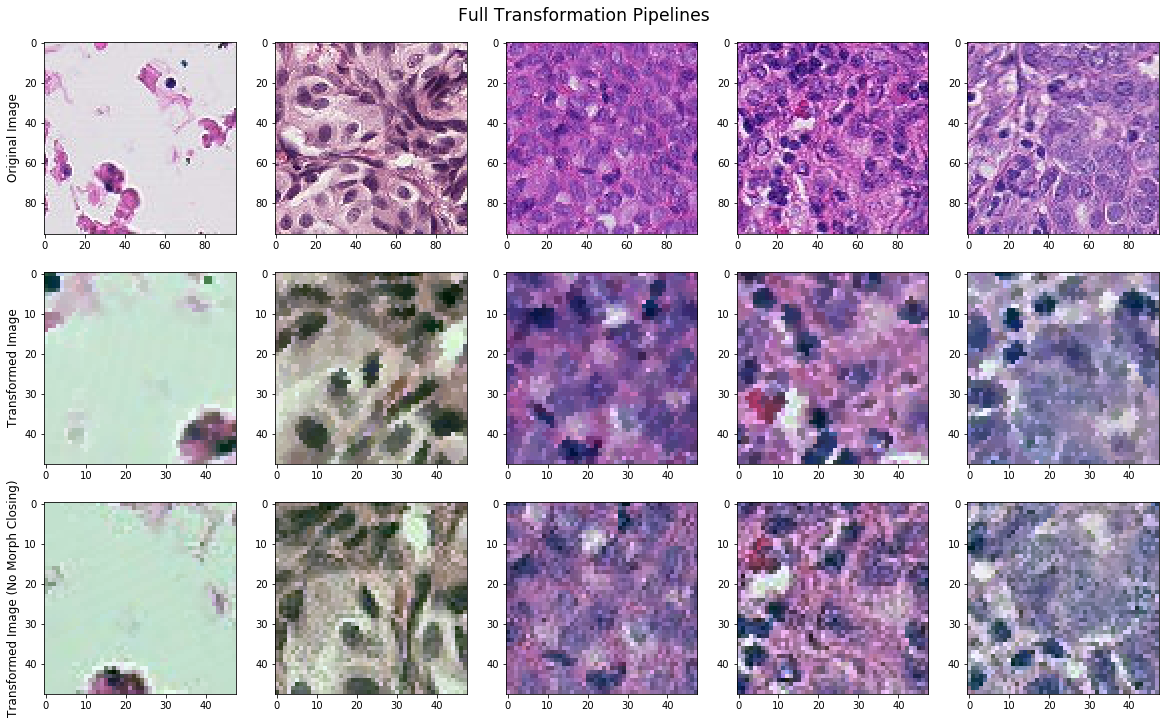

In [13]:
fig, ax = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle('Full Transformation Pipelines', size='xx-large', y=0.92)
for i in range(5):
    ax[0, i].imshow(pcam_dataset[i])
    T1 = transform_image(pcam_dataset[i])
    T1 = (T1 + T1.min().abs())/(T1.max() - T1.min())
    ax[1, i].imshow(T1.permute(1, 2, 0).numpy())
    T2 = transform_image_no_morph(pcam_dataset[i])
    T2 = (T2 + T2.min().abs())/(T2.max() - T2.min())
    ax[2, i].imshow(T2.permute(1, 2, 0).numpy())
ax[0,0].set_ylabel(f'Original Image', size='large')
ax[1,0].set_ylabel(f'Transformed Image', size='large')
ax[2,0].set_ylabel(f'Transformed Image (No Morph Closing)', size='large')
plt.savefig('../figures/full_transform_comparison.png')